In [2]:
#importing required Libraries
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch 
import torchvision as tv
from torchsummary import summary
from torchmetrics.classification import Accuracy
import lightning as Light
# import ignite
%matplotlib inline

In [3]:
# Chech if CUDA is working, set appropriate device
device = None
device_str = None
if torch.cuda.is_available():
    print("CUDA working")
    device_str = 'cuda'
    print(f"This user has a {torch.cuda.get_device_name(0)}") # flex your GPUs here
else:
    print("CUDA not working - running on CPU")
    device_str = 'cpu'

device = torch.device(device_str)


CUDA working
This user has a NVIDIA GeForce GTX 1650 Ti


In [6]:
train_dataset_path = 'dataset/data/train'
test_dataset_path = 'dataset/data/test'
validation_dataset_path = 'dataset/data/val'

In [7]:
training_transforms = tv.transforms.Compose([tv.transforms.Resize((112,112)), tv.transforms.ToTensor()])
train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = training_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)

def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

    mean /= total_images_count
    std /= total_images_count

    return mean, std

mean, std = get_mean_and_std(train_loader)

In [8]:
mean = mean[0]
std = std[0]
IMG_SIZE = (256,256)

# We can use 3 input channels (r,g,b) or covert it to grayscale for 1 channel

train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),       # need to use the same resize size or else std changes for each size
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.Grayscale(num_output_channels=1), 
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])
rgb_train_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),       # need to use the same resize size or else std changes for each size
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

test_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.Grayscale(num_output_channels=1), 
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

rgb_test_transforms = tv.transforms.Compose([
    tv.transforms.Resize(IMG_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(15),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

In [9]:
train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = tv.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)
validation_dataset = tv.datasets.ImageFolder(root = validation_dataset_path, transform = test_transforms)
rgb_train_dataset = tv.datasets.ImageFolder(root = train_dataset_path, transform = rgb_train_transforms)
rgb_test_dataset = tv.datasets.ImageFolder(root = test_dataset_path, transform = rgb_test_transforms)
rgb_validation_dataset = tv.datasets.ImageFolder(root = validation_dataset_path, transform = rgb_test_transforms)

In [10]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = tv.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4351628..2.501322].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4351628..2.501322].


labels:  tensor([0, 0, 1, 1, 0, 0])
labels:  tensor([0, 1, 1, 1, 1, 1])


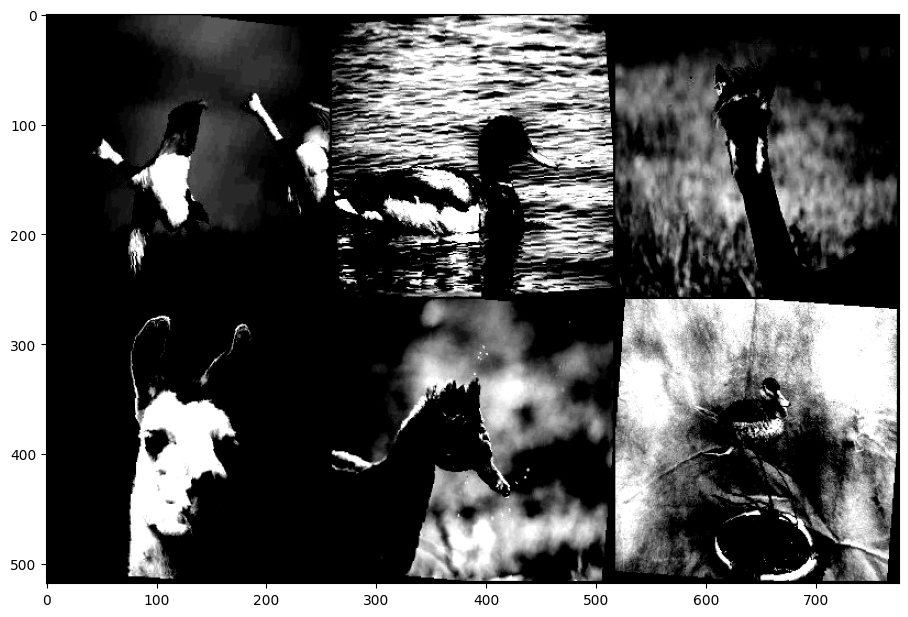

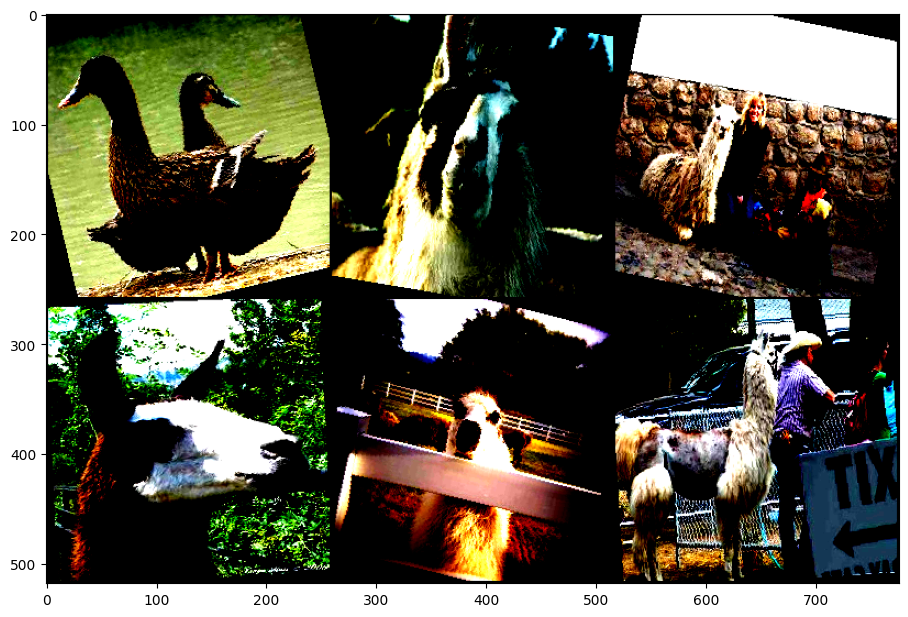

In [12]:
show_transformed_images(train_dataset)
show_transformed_images(rgb_train_dataset)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle=False)
rgb_train_loader = torch.utils.data.DataLoader(rgb_train_dataset, batch_size = 64, shuffle=True)
rgb_test_loader = torch.utils.data.DataLoader(rgb_test_dataset, batch_size = 64, shuffle=False)
rgb_validation_loader = torch.utils.data.DataLoader(rgb_validation_dataset, batch_size = 64, shuffle=False)

In [14]:
def accuracy(preds, y):
    _,preds = torch.max(preds, dim=1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))

In [15]:
def evaluate(model, dataloader, criterion, optimizer):
    criterion=criterion.to(device)
    model.eval()
    preds = []
    y_true = []
    losses=[]
    accuracies = []
    for X,y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        losses.append(loss.item())
        accuracies.append(accuracy(y_hat, y))
        preds.append(torch.argmax(y_hat, axis=1))
        y_true.append(y)
    mean_loss = sum(losses)/len(losses)
    mean_acc = sum(accuracies)/len(accuracies)
    del model, dataloader,criterion
    return mean_loss, mean_acc


def fit(model, model_name, criterion, optimizer, epochs=1, rgb=False, verbose=1):
    # define the loss function
    # determine the gradient descent algorithm to be used for updating weights

    curr_model = model.to(device)
    criterion = criterion.to(device)
    retry = 0
    correct_train_loader = rgb_train_loader if rgb else train_loader
    correct_validation_loader = rgb_validation_loader if rgb else validation_loader
    correct_test_loader = rgb_test_loader if rgb else test_loader
    for epoch in tqdm(range(epochs)): 
        try:
            model.train()
            for X,y in correct_train_loader: 
                X, y = X.to(device), y.to(device)
                yhat = curr_model(X) 
                loss = criterion(yhat, y) 

                # backward prop for loss function and calculate gradients of all the layers in the net
                loss.backward()    
                # update the weights   
                optimizer.step()         
                # make the gradients zero before next step so that they don't accumulate
                optimizer.zero_grad()   

            val_loss, val_acc = evaluate(model, correct_validation_loader, criterion)
            #  TODO if val loss increasing or not improving, don't do more epochs

            if verbose>1: print(f"Epoch: {epoch} training loss is: {loss.item()}")
            if verbose: print(f"Validation Loss: {val_loss}, Accuracy: {val_acc}")
        except torch.cuda.OutOfMemoryError as e:
            print(e)
            if retry>2:
                break
            else:
                torch.cuda.empty_cache()
                retry+=1
    # save model so it doesnt need to be retrained
    with open(model_name+'.pt', 'wb') as f: 
        torch.save(curr_model.state_dict(), f) 

    test_loss, test_acc = evaluate(model, correct_test_loader, criterion, optimizer)
    if verbose: print(f"test Loss: {test_loss}, Accuracy: {test_acc}")
    del model, criterion


In [ ]:
model_name= "name"
curr_model = None #model
criterion = None #Loss i.e. torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(curr_model.parameters(), lr = 1e-3)
# open a previously trained model
try:
    with open(model_name+'.pt', 'rb') as f:
        curr_model.load_state_dict(torch.load(f))  
except FileNotFoundError:
    print("Model does not exist yet")
    
fit(model=curr_model, model_name=model_name, criterion=criterion, optimizer=optimizer, epochs = 10, rgb=True, verbose = 2)